### SI figure notebook to simulate downsampled MERFISH single cell analysis to compare with scRNA-seq

In [6]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
import anndata
import scanpy
import string
import seaborn as sns
import h5py
import math
%matplotlib inline

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,8])
    plt.rc('svg', fonttype='none')

# To do: 

In [2]:
# Define the path of the analyzed data
dataPath = '../../../MERlin_Analysis/ProcessedResults/'

# Define the experiment
experimentName = 'Msliver_Cellboundary_PM1_12172020'
prefixCounts = 'RawCounts/'
suffixCounts = '_FilteredSingleCellCounts.csv'

# Load the MERlin results
# Note that this assumes the data has already been filtered through the MERlin_quality_control notebook

# Raw counts per segmented cell
VizgenCounts = pd.read_csv(dataPath + prefixCounts + experimentName + suffixCounts)

# Filter out cells with abnormally low counts
threshold = 4 #Reject cells with total count fewer than this to make it comparable to 10X, which has the same threshold
LowCountsInd = VizgenCounts.sum(axis=1) < threshold
VizgenCounts = VizgenCounts.loc[~LowCountsInd]

# Load MACA data (10X)
dataPathMACA = '../../../../../../../data/angela/maca/tabula-muris-senis/0_data_ingest/01_figure_1'
experimentMACA10X = 'tabula-muris-senis-droplet-official-raw-obj.h5ad'

MACA_10X_h5ad = anndata.read_h5ad(os.path.join(dataPathMACA, experimentMACA10X))

# Select only the liver cells
MACAliver_10X_h5ad = MACA_10X_h5ad[MACA_10X_h5ad.obs['tissue'] == 'Liver']

# Get the gene expression matrix (this is clunky but I want more experience manipulating the data)
MACAliver_10X = MACAliver_10X_h5ad.to_df()

# Select PM1 gene panel genes only
MACAliver_10X = MACAliver_10X[list(VizgenCounts.columns)]

/home/jonathan.liu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


/home/jonathan.liu/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


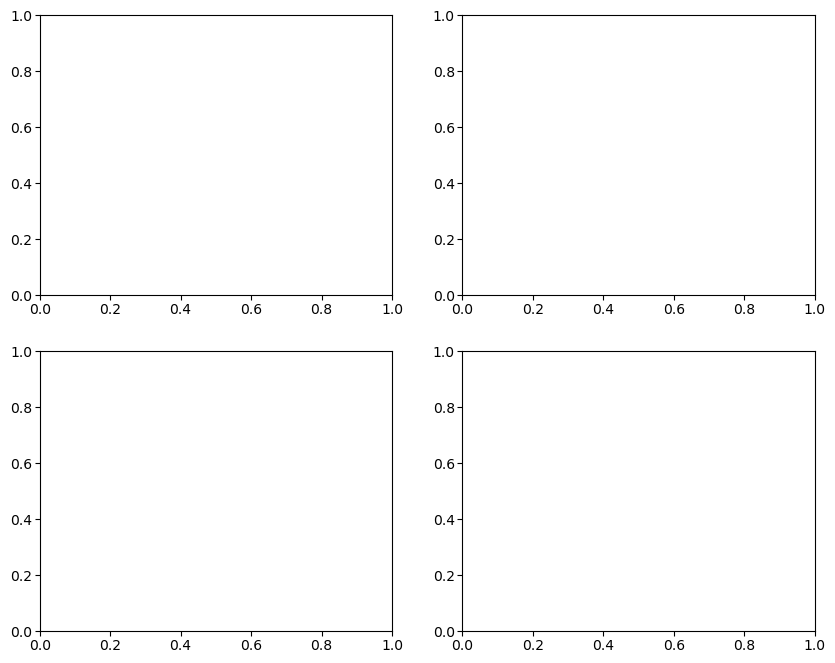

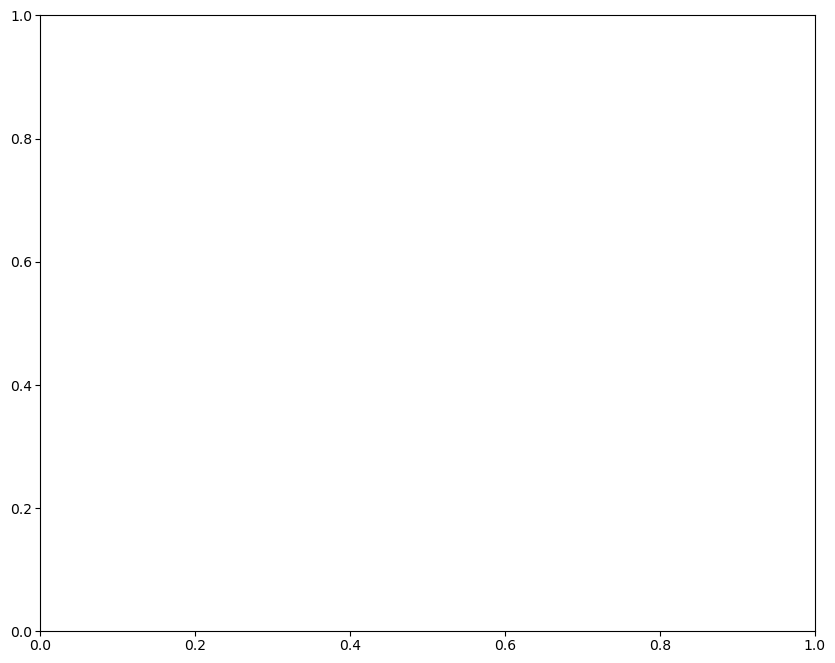

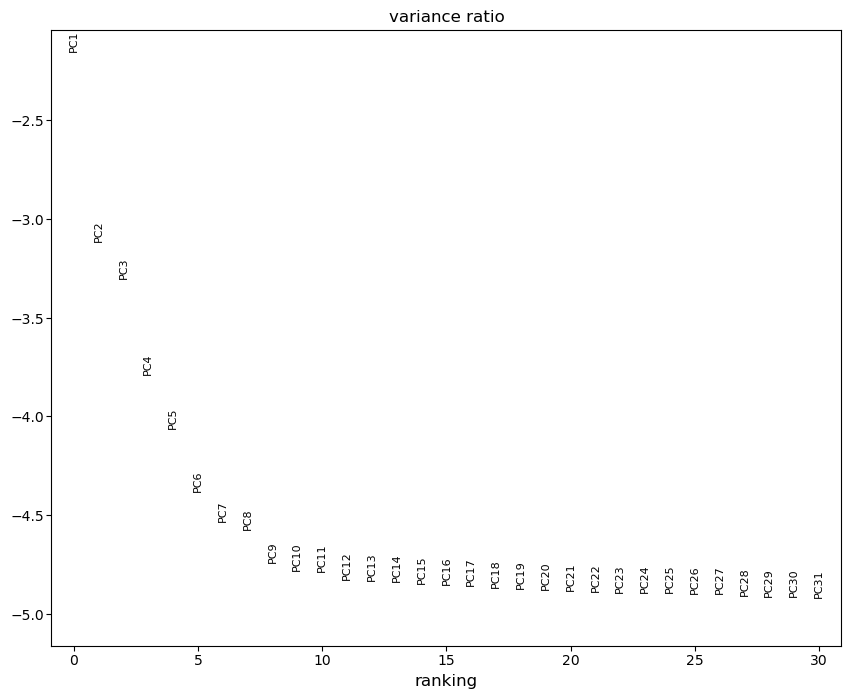

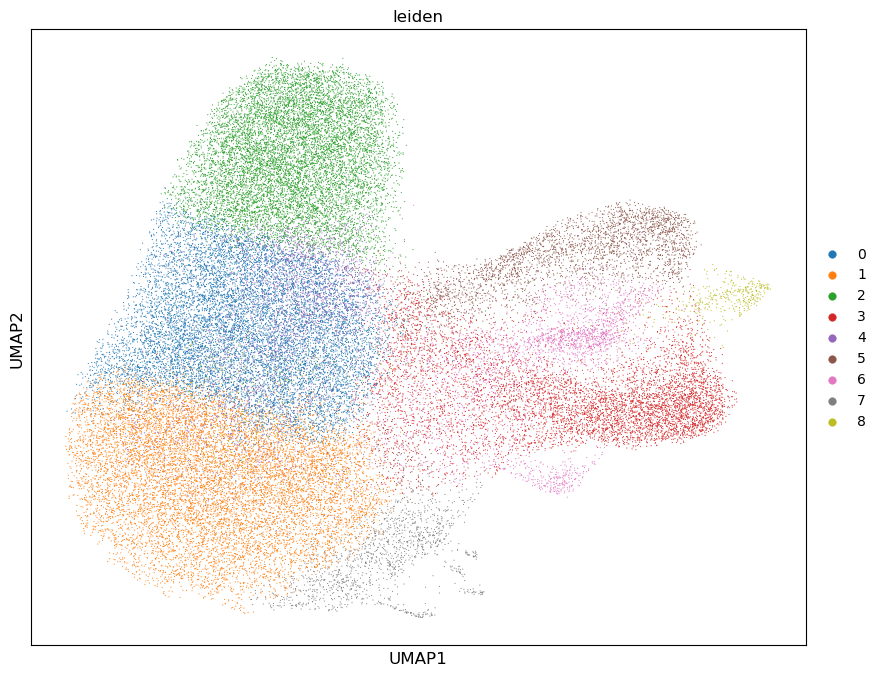

In [8]:
# First, examine the raw Vizgen dataset

ad_Vizgen = anndata.AnnData(VizgenCounts)

N_counts_filter = 0 #Counts/cell filtering threshold

# Save a copy of the raw counts
ad_Vizgen_raw = []
# Preprocess the Anndata objects

scanpy.pp.filter_cells(ad_Vizgen, min_counts=N_counts_filter) #Filter based on total counts per cell
ad_Vizgen_raw.append(ad_Vizgen.copy()) #Save a copy of the raw counts
scanpy.pp.normalize_total(ad_Vizgen, target_sum=1e4) #Normalize the data to 10k counts
scanpy.pp.log1p(ad_Vizgen) #Logarithmize the data
scanpy.pp.scale(ad_Vizgen, max_value=10) #Scale each gene to unit variance and clip SD values over 10
scanpy.tl.pca(ad_Vizgen, svd_solver='arpack') #Compute PCA
    
# Plot the PCA variance ratios
scanpy.pl.pca_variance_ratio(ad_Vizgen, log=True)

# Calculate the individual UMAPs and do leiden clustering
scanpy.pp.neighbors(ad_Vizgen, n_neighbors=15, n_pcs=10) #Compute neighborhood graph (use n_neighbors = 12-15?)
scanpy.tl.umap(ad_Vizgen) #Compute UMAP embedding
scanpy.tl.leiden(ad_Vizgen, resolution=0.5)

# Plot the clustering results
scanpy.pl.umap(ad_Vizgen, color='leiden')

/home/jonathan.liu/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


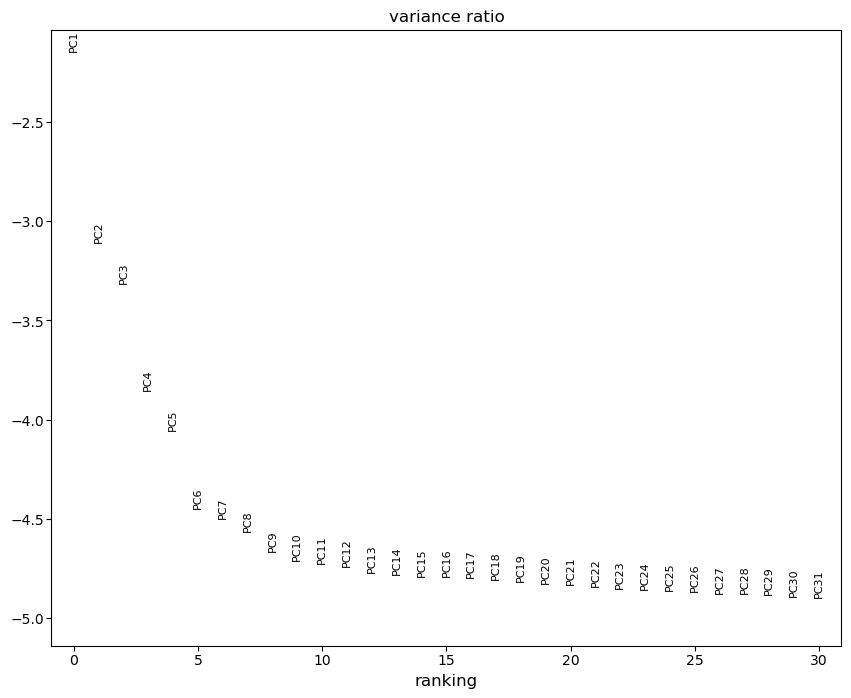

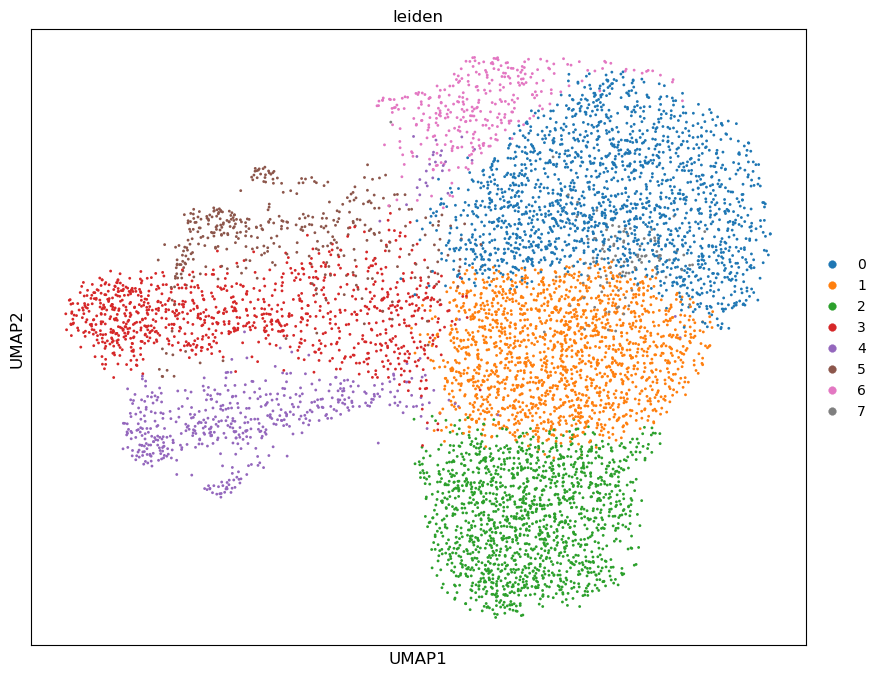

In [9]:
# Now, randomly sample the Vizgen data to have the same number of total cells as MACA
N_Vizgen = VizgenCounts.shape[0]
N_MACA_10X = MACAliver_10X.shape[0]

VizgenCounts_sample = VizgenCounts.sample(n=N_MACA_10X,axis=0)

ad_Vizgen_sample = anndata.AnnData(VizgenCounts_sample)

N_counts_filter = 0 #Counts/cell filtering threshold

# Preprocess the Anndata objects

scanpy.pp.filter_cells(ad_Vizgen_sample, min_counts=N_counts_filter) #Filter based on total counts per cell
scanpy.pp.normalize_total(ad_Vizgen_sample, target_sum=1e4) #Normalize the data to 10k counts
scanpy.pp.log1p(ad_Vizgen_sample) #Logarithmize the data
scanpy.pp.scale(ad_Vizgen_sample, max_value=10) #Scale each gene to unit variance and clip SD values over 10
scanpy.tl.pca(ad_Vizgen_sample, svd_solver='arpack') #Compute PCA
    
# Plot the PCA variance ratios
scanpy.pl.pca_variance_ratio(ad_Vizgen_sample, log=True)

# Calculate the individual UMAPs and do leiden clustering
scanpy.pp.neighbors(ad_Vizgen_sample, n_neighbors=15, n_pcs=10) #Compute neighborhood graph (use n_neighbors = 12-15?)
scanpy.tl.umap(ad_Vizgen_sample) #Compute UMAP embedding
scanpy.tl.leiden(ad_Vizgen_sample, resolution=0.5)

# Plot the clustering results
scanpy.pl.umap(ad_Vizgen_sample, color='leiden')

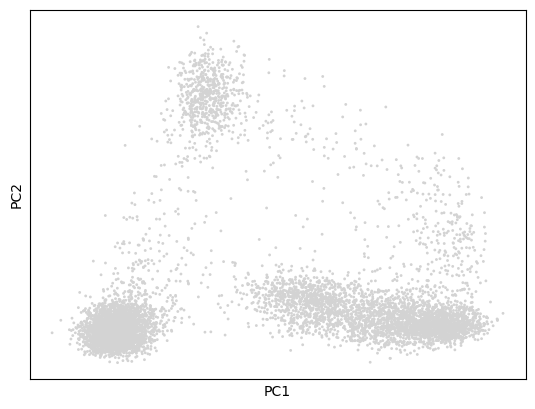

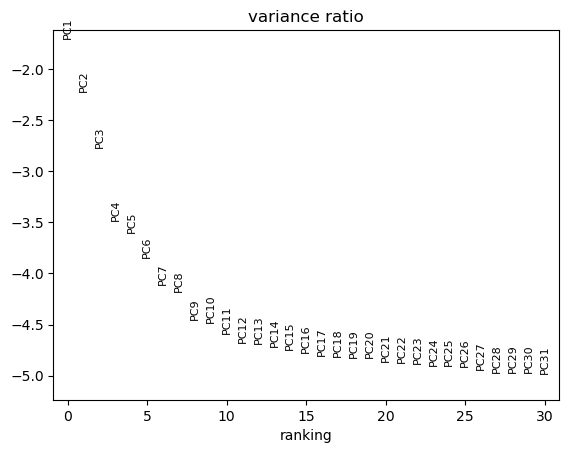

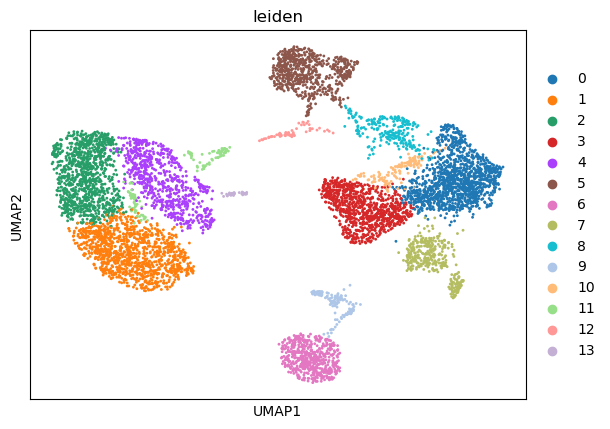

In [5]:
# MACA for comparison
ad2_MACA = anndata.AnnData(MACAliver_10X)

scanpy.pp.filter_cells(ad2_MACA, min_counts=0) #Filter based on total counts per cell
ad2_MACA_raw = ad2_MACA.copy() #Save a copy of the raw counts for scVI analysis later

scanpy.pp.normalize_total(ad2_MACA, target_sum=1e4) #Normalize the data
scanpy.pp.log1p(ad2_MACA) #Logarithmize the data
scanpy.pp.scale(ad2_MACA, max_value=10) #Scale each gene to unit variance and clip SD values over 10
scanpy.tl.pca(ad2_MACA, svd_solver='arpack') #Compute PCA
scanpy.pl.pca(ad2_MACA) #Plot PCs
scanpy.pl.pca_variance_ratio(ad2_MACA, log=True) #Plot PCA variance ratios
scanpy.pp.neighbors(ad2_MACA, n_neighbors=15, n_pcs=10) #Compute neighborhood graph
scanpy.tl.umap(ad2_MACA) #Compute UMAP embedding
scanpy.tl.leiden(ad2_MACA, resolution=0.5)
scanpy.pl.umap(ad2_MACA, color='leiden') #Plot UMAP

### Plot final figure

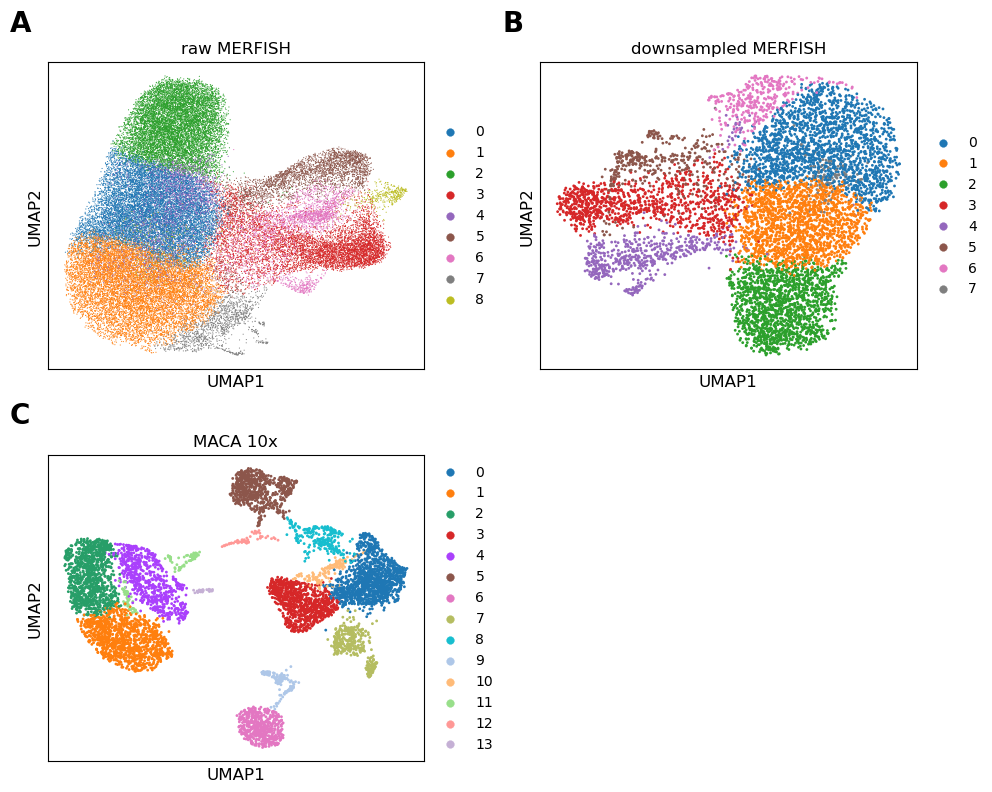

In [19]:
set_plotting_style()

fig, ax = plt.subplots(2,2)

ax[0,0] = scanpy.pl.umap(ad_Vizgen, ax=ax[0,0], color='leiden', title='raw MERFISH', show=False)
ax[0,1] = scanpy.pl.umap(ad_Vizgen_sample, ax=ax[0,1], color='leiden', title='downsampled MERFISH', show=False)
ax[1,0] = scanpy.pl.umap(ad2_MACA, ax=ax[1,0], color='leiden', title='MACA 10x', show=False)
ax[1,1].remove()

# Label subpanels
axes = ax.flat
for n, ax in enumerate(axes):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
fig.tight_layout()
fig


In [20]:
# Export figures
fig.savefig('../../figures/SIFig_simulated_downsampling.pdf')
fig.savefig('../../figures/SIFig_simulated_downsampling.png')